<a href="https://www.kaggle.com/code/keloggs/brain-tumor-detection-into-17-classes-resnet50?scriptVersionId=191070062" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries
    => os: Allows interaction with the operating system, enabling tasks such as navigating directories, creating folders, etc.

    => numpy: Provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.

    => tensorflow: An open-source machine learning framework that provides tools for building and training machine learning models, particularly neural networks.

    => keras: A high-level neural networks API, written in Python and capable of running on top of TensorFlow, among other frameworks. It provides a user-friendly interface for building and training deep learning models.

In [1]:
import os
import numpy as np
import tensorflow
import keras

    => ImageDataGenerator: Augments image data during the training process, enhancing model performance and generalization by generating variations of the images.

    => ResNet50: A pre-trained deep learning model known for its performance in image recognition tasks. It can be used directly or fine-tuned for specific tasks.

    => preprocess_input: Pre-processes input data to be compatible with the ResNet50 model.

    => Sequential: Provides a linear stack of layers for building deep learning models layer-by-layer.

    => Dense, Dropout, Flatten: Different types of layers used in neural networks: Dense creates fully connected layers, Dropout helps prevent overfitting by randomly disabling neurons, and Flatten converts multi-dimensional data into a 1D array.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

    => regularizers: Provides options for applying regularization techniques to neural network layers to prevent overfitting.

    => AdamW: An optimizer that combines the benefits of the Adam optimizer with weight decay, improving model performance.

    => matplotlib.pyplot: Allows for data visualization, particularly creating charts, plots, histograms, and other visual representations of data.

    => ReduceLROnPlateau (from keras.callbacks): Reduces the learning rate when a metric has stopped improving, helping the model to converge more efficiently during training.

In [3]:
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers.experimental import AdamW

import matplotlib.pyplot as plt

from keras.callbacks import ReduceLROnPlateau,EarlyStopping

# Loading dataset and creating DataLoader(ImageDataGenerator)

**List of different types of Tumors in the dataset**

In [4]:
!ls /kaggle/input/brain-tumor-mri-images-17-classes

'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1'
'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+'
'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2'
'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1'
'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+'
'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2'
'NORMAL T1'
'NORMAL T2'
'Neurocitoma (Central - Intraventricular, Extraventricular) T1'
'Neurocitoma (Central - Intraventricular, Extraventricular) T1C+'
'Neurocitoma (Central - Intraventricular, Extraventricular) T2'
'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1'
'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1C+'
'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T2'
'Schwannoma (Acustico, Vestibular - Trigeminal) T1'
'Schwannoma (Acustico, Vestibular - Trigeminal

In [5]:
class_size = len(os.listdir('/kaggle/input/brain-tumor-mri-images-17-classes'))

Total number of classes in the dataset => 17 

In [6]:
class_size

17

Create the DataLoader object with preprocessing funtion of resnet50 and validation split of 20 percent

In [7]:
data_generator=ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.20)

In [8]:
dataset_dir='/kaggle/input/brain-tumor-mri-images-17-classes'

ImageDataLoader for training split

In [9]:
train_capsule = data_generator.flow_from_directory(
    dataset_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='training'

)

Found 3539 images belonging to 17 classes.


ImageDataLoader for validation split

In [10]:
valid_capsule = data_generator.flow_from_directory(
    dataset_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'

)

Found 876 images belonging to 17 classes.


In [11]:
def plot_graph(history,model):
    epochs = [i for i in range(len(history.history['loss']))]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.suptitle(f"Accuracy and loss for {model}")
    plt.show()

In [12]:
model1 = Sequential()
model1.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
))
model1.add(Dense(256, activation='relu',kernel_regularizer='l2'))
model1.add(Dropout(0.3))
model1.add(Dense(256, activation='relu',kernel_regularizer='l2'))
model1.add(Dropout(0.3))
model1.add(Dense(44,activation='relu',kernel_regularizer='l2'))
model1.add(Dropout(0.2))
model1.add(Dense(class_size,activation='softmax'))
model1.layers[0].trainable = False
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
red_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3,min_lr=0.00000001)
early_stop=EarlyStopping(monitor='val_loss',patience=5,mode='min',restore_best_weights=True,start_from_epoch=10)

94765736/94765736 [==============================] - 1s 0us/step


In [13]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 44)                11308     
                                                                 
 dropout_2 (Dropout)         (None, 44)                0

In [14]:
fit_history1 = model1.fit(
    train_capsule,
    steps_per_epoch=len(train_capsule),
    epochs = 80,
    validation_data=valid_capsule,
    validation_steps=len(valid_capsule),
    verbose = 1,
    callbacks=[red_lr,early_stop]
)

Epoch 1/80
222/222 [==============================] - 46s 166ms/step - loss: 5.1799 - accuracy: 0.2780 - val_loss: 2.9999 - val_accuracy: 0.4498 - lr: 0.0010
Epoch 2/80
222/222 [==============================] - 25s 112ms/step - loss: 2.6370 - accuracy: 0.4566 - val_loss: 2.2187 - val_accuracy: 0.5034 - lr: 0.0010
Epoch 3/80
222/222 [==============================] - 25s 110ms/step - loss: 2.0731 - accuracy: 0.5507 - val_loss: 1.8567 - val_accuracy: 0.5902 - lr: 0.0010
Epoch 4/80
222/222 [==============================] - 25s 113ms/step - loss: 1.8717 - accuracy: 0.5781 - val_loss: 1.7624 - val_accuracy: 0.5913 - lr: 0.0010
Epoch 5/80
222/222 [==============================] - 24s 110ms/step - loss: 1.7037 - accuracy: 0.6120 - val_loss: 1.6474 - val_accuracy: 0.6324 - lr: 0.0010
Epoch 6/80
222/222 [==============================] - 25s 114ms/step - loss: 1.5757 - accuracy: 0.6507 - val_loss: 1.4945 - val_accuracy: 0.6804 - lr: 0.0010
Epoch 7/80
222/222 [==============================] 

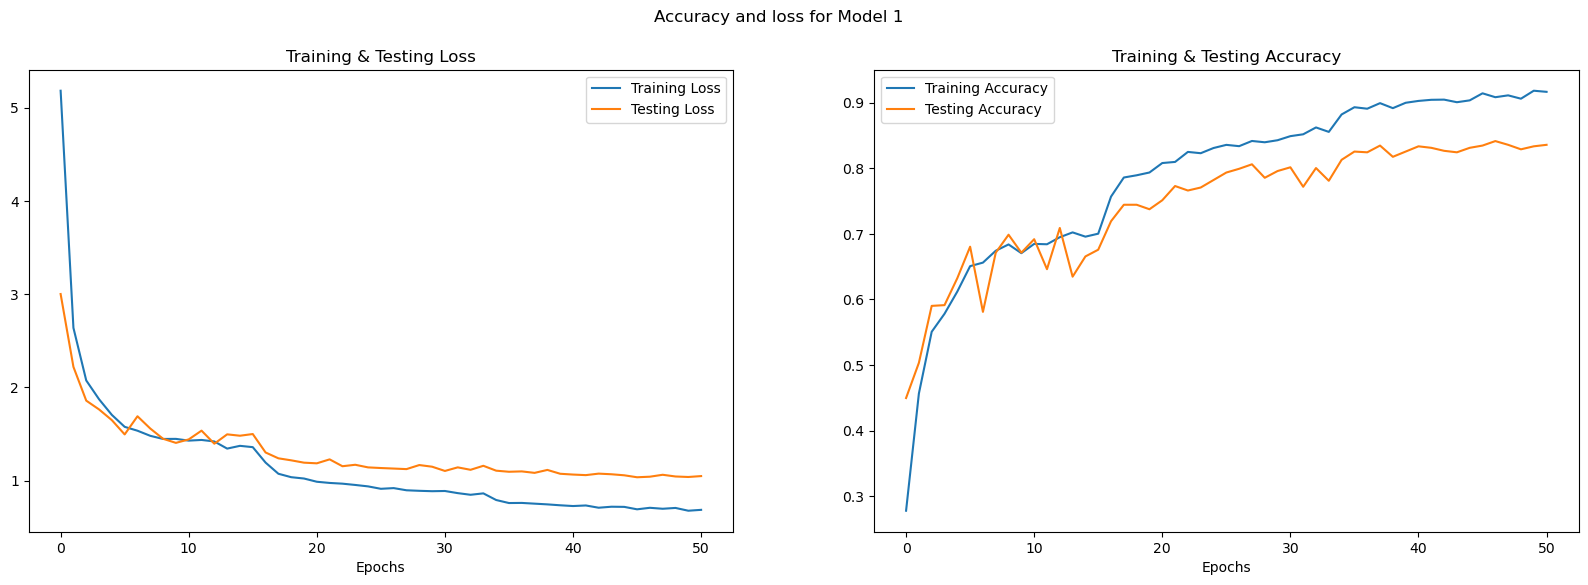

In [15]:
plot_graph(fit_history1,"Model 1")

In [16]:
model1.save('tumor_detection_1.h5')

In [17]:
model2 = Sequential()
model2.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
))
model2.add(Flatten())
model2.add(Dense(1024, activation='relu',kernel_regularizer='l2'))
model2.add(Dropout(0.3))
model2.add(Dense(256, activation='relu',kernel_regularizer='l2'))
model2.add(Dropout(0.3))
model2.add(Dense(44,activation='relu',kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Dense(class_size,activation='softmax'))
model2.layers[0].trainable = False
model2.compile(optimizer='RMSprop', loss='categorical_crossentropy',metrics=['accuracy'])
red_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3,min_lr=0.00000001,verbose=1)
early_stop=EarlyStopping(monitor='val_loss',patience=5,mode='min',restore_best_weights=True,start_from_epoch=10)

In [18]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 44)               

In [19]:
fit_history2 = model2.fit(
    train_capsule,
    steps_per_epoch=len(train_capsule),
    epochs = 80,
    validation_data=valid_capsule,
    validation_steps=len(valid_capsule),
    verbose = 1,
    callbacks=[red_lr,early_stop]
)

Epoch 1/80
222/222 [==============================] - 31s 116ms/step - loss: 5.6529 - accuracy: 0.2034 - val_loss: 2.3720 - val_accuracy: 0.3482 - lr: 0.0010
Epoch 2/80
222/222 [==============================] - 25s 113ms/step - loss: 2.2680 - accuracy: 0.3620 - val_loss: 2.0417 - val_accuracy: 0.4361 - lr: 0.0010
Epoch 3/80
222/222 [==============================] - 25s 113ms/step - loss: 1.9155 - accuracy: 0.4821 - val_loss: 1.7606 - val_accuracy: 0.5468 - lr: 0.0010
Epoch 4/80
222/222 [==============================] - 25s 111ms/step - loss: 1.7216 - accuracy: 0.5445 - val_loss: 1.6361 - val_accuracy: 0.5605 - lr: 0.0010
Epoch 5/80
222/222 [==============================] - 25s 113ms/step - loss: 1.6284 - accuracy: 0.5875 - val_loss: 1.7525 - val_accuracy: 0.5662 - lr: 0.0010
Epoch 6/80
222/222 [==============================] - 24s 110ms/step - loss: 1.5708 - accuracy: 0.6098 - val_loss: 1.5301 - val_accuracy: 0.6416 - lr: 0.0010
Epoch 7/80
222/222 [==============================] 

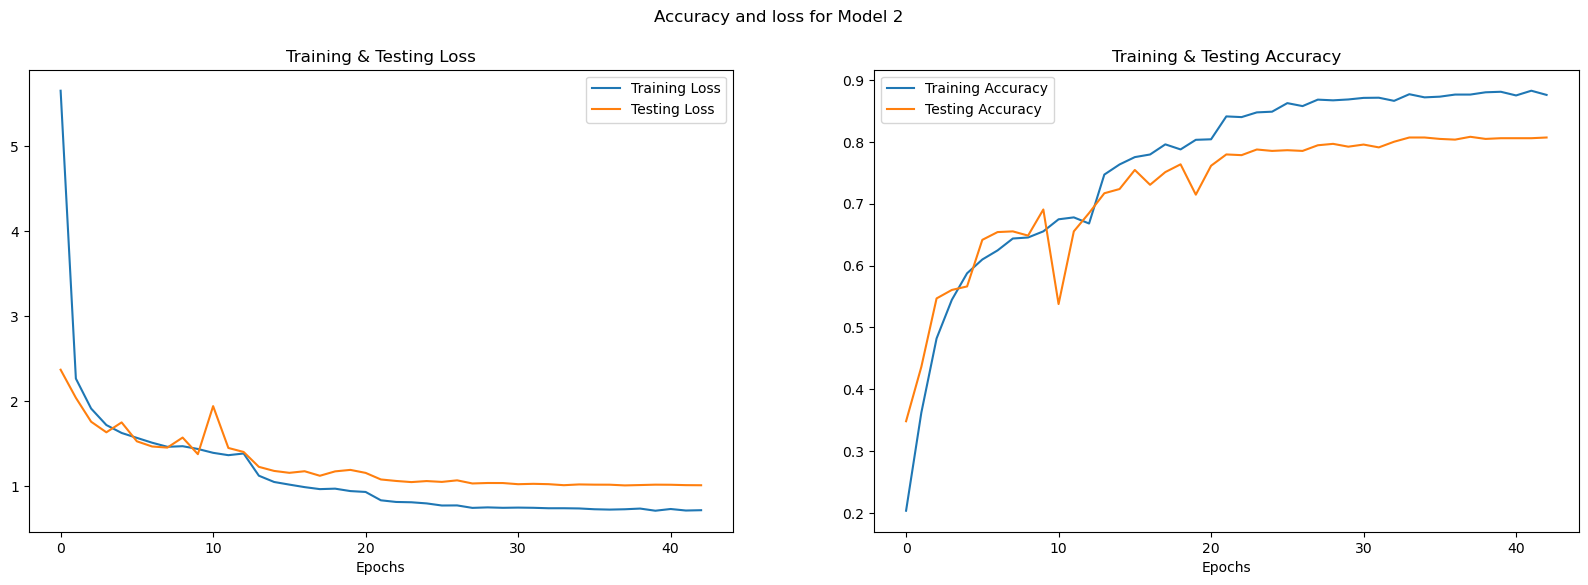

In [20]:
plot_graph(fit_history2, "Model 2")

In [21]:
model2.save('tumor_detection_2.h5')

In [22]:
model3 = Sequential()
model3.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
))
model3.add(Flatten())
model3.add(Dense(1024, activation='relu',kernel_regularizer='l2'))
model3.add(Dropout(0.5))
model3.add(Dense(256, activation='relu',kernel_regularizer='l2'))
model3.add(Dropout(0.2))
model3.add(Dense(44,activation='relu',kernel_regularizer='l2'))
#model1.add(Dropout(0.3))
model3.add(Dense(class_size,activation='softmax'))
model3.layers[0].trainable = False
opt = tensorflow.keras.optimizers.experimental.AdamW()
model3.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
red_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3,min_lr=0.00000001,verbose=1)
early_stop=EarlyStopping(monitor='val_loss',patience=5,mode='min',restore_best_weights=True,start_from_epoch=10)

In [23]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               262400    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 44)               

In [24]:
fit_history3 = model3.fit(
    train_capsule,
    steps_per_epoch=len(train_capsule),
    epochs =80,
    validation_data=valid_capsule,
    validation_steps=len(valid_capsule),
    verbose = 1,
    callbacks=[red_lr,early_stop]
)

Epoch 1/80
222/222 [==============================] - 31s 118ms/step - loss: 7.2220 - accuracy: 0.2910 - val_loss: 3.4818 - val_accuracy: 0.4018 - lr: 0.0010
Epoch 2/80
222/222 [==============================] - 24s 110ms/step - loss: 2.9315 - accuracy: 0.4569 - val_loss: 2.5079 - val_accuracy: 0.4977 - lr: 0.0010
Epoch 3/80
222/222 [==============================] - 25s 113ms/step - loss: 2.3266 - accuracy: 0.5137 - val_loss: 2.1188 - val_accuracy: 0.5434 - lr: 0.0010
Epoch 4/80
222/222 [==============================] - 24s 110ms/step - loss: 2.0513 - accuracy: 0.5603 - val_loss: 2.0359 - val_accuracy: 0.5137 - lr: 0.0010
Epoch 5/80
222/222 [==============================] - 24s 110ms/step - loss: 1.9274 - accuracy: 0.5533 - val_loss: 1.9053 - val_accuracy: 0.5708 - lr: 0.0010
Epoch 6/80
222/222 [==============================] - 25s 111ms/step - loss: 1.8327 - accuracy: 0.5875 - val_loss: 1.8911 - val_accuracy: 0.5890 - lr: 0.0010
Epoch 7/80
222/222 [==============================] 

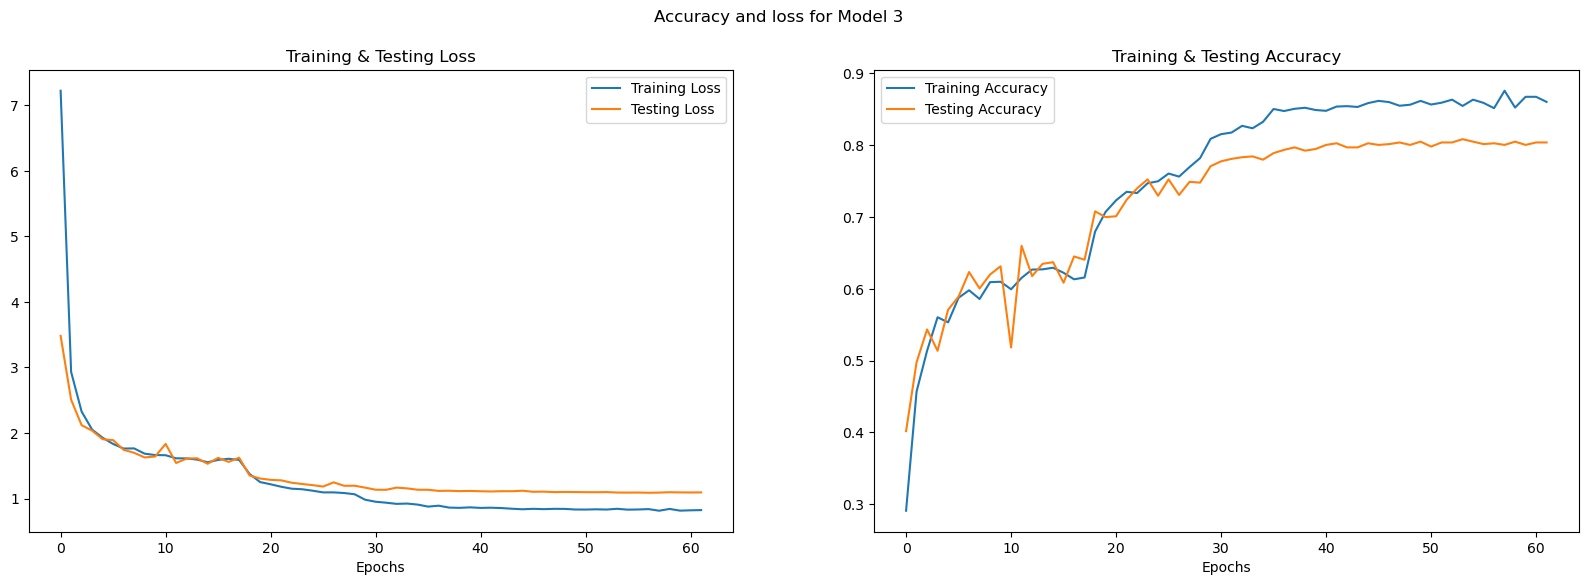

In [25]:
plot_graph(fit_history3,"Model 3")

In [26]:
model3.save('tumor_detection_3.h5')

In [27]:
labels = {value: key for key, value in train_capsule.class_indices.items()}
print(labels)

{0: 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1', 1: 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+', 2: 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2', 3: 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1', 4: 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+', 5: 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2', 6: 'NORMAL T1', 7: 'NORMAL T2', 8: 'Neurocitoma (Central - Intraventricular, Extraventricular) T1', 9: 'Neurocitoma (Central - Intraventricular, Extraventricular) T1C+', 10: 'Neurocitoma (Central - Intraventricular, Extraventricular) T2', 11: 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1', 12: 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1C+', 13: 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T2', 14: 'Schwannoma (Acustico, Vestibular

In [28]:
def predi(path_image, path_model):
    import tensorflow as tf
    import numpy as np
    import matplotlib.pyplot as plt 
    labels = {0: 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1', 
              1: 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+', 
              2: 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2', 
              3: 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1', 
              4: 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+', 
              5: 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2', 
              6: 'NORMAL T1', 
              7: 'NORMAL T2', 
              8: 'Neurocitoma (Central - Intraventricular, Extraventricular) T1', 
              9: 'Neurocitoma (Central - Intraventricular, Extraventricular) T1C+', 
              10: 'Neurocitoma (Central - Intraventricular, Extraventricular) T2', 
              11: 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1', 
              12: 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1C+', 
              13: 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T2', 
              14: 'Schwannoma (Acustico, Vestibular - Trigeminal) T1', 
              15: 'Schwannoma (Acustico, Vestibular - Trigeminal) T1C+', 
              16: 'Schwannoma (Acustico, Vestibular - Trigeminal) T2'}
    model=tf.keras.models.load_model(path_model)
    img=tf.keras.utils.load_img(path_image, target_size=(224,224))
    img_arr=tf.keras.utils.img_to_array(img)
    x = preprocess_input(np.expand_dims(img_arr.copy(), axis=0)) 
    prediction=model.predict(x)
    predicted_label = labels[np.argmax(prediction)]
    plt.title(f"Prediction: {predicted_label}")
    plt.imshow(img)
    plt.axis("off")

In [29]:
path_to_image = "/kaggle/input/brain-tumor-mri-images-17-classes/Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2/glioma (109).jpeg"

Model 1
1/1 [==============================] - 1s 1s/step


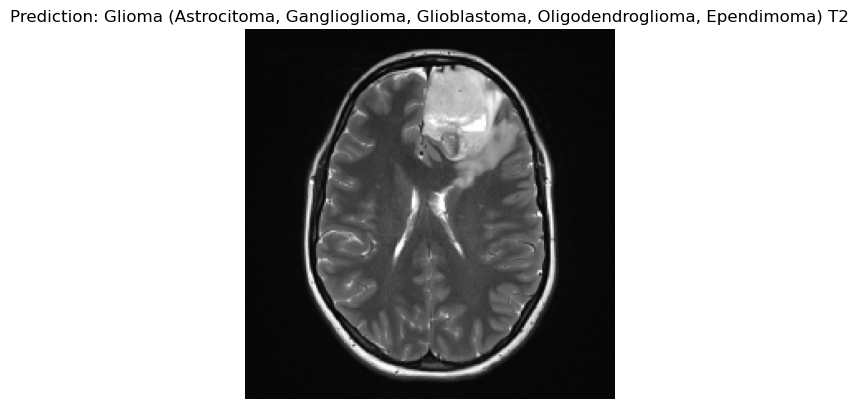

In [30]:
print("Model 1")
predi(path_to_image,'/kaggle/working/tumor_detection_1.h5')

Model 2
1/1 [==============================] - 1s 960ms/step


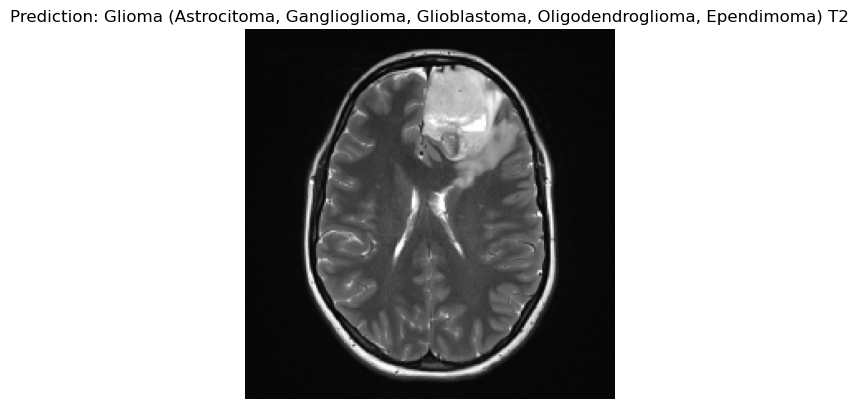

In [31]:
print("Model 2")
predi(path_to_image,'/kaggle/working/tumor_detection_2.h5')

Model 3
1/1 [==============================] - 1s 946ms/step


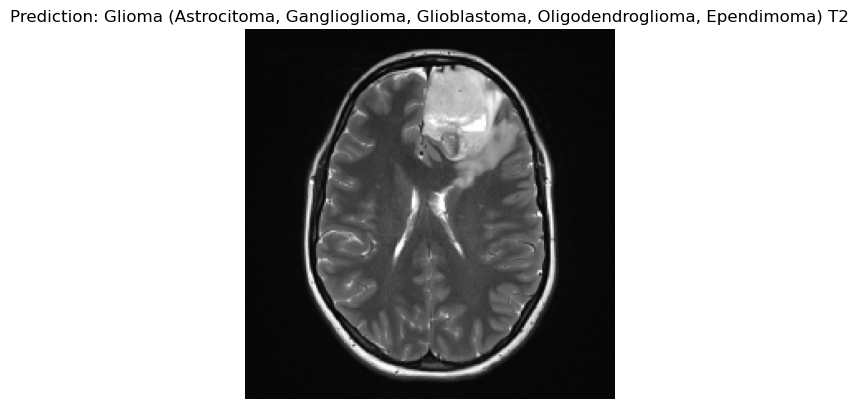

In [32]:
print("Model 3")
predi(path_to_image,'/kaggle/working/tumor_detection_3.h5')